# Data Preprocessing and Augmentation Pipeline

This notebook demonstrates the complete preprocessing pipeline for chest X-ray images, including:
- Image resizing to 224×224 (standard for transfer learning)
- Normalization using ImageNet statistics
- Data augmentation strategies
- Train vs Test transforms (preventing data leakage)

In [9]:
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data

# Add src to path
sys.path.append('../')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print("Libraries imported successfully!")

PyTorch version: 2.10.0
Torchvision version: 0.25.0
CUDA available: False
Libraries imported successfully!


## 📐 Define Preprocessing Constants

Standard configurations for medical image preprocessing.

In [10]:
# Preprocessing configuration
IMAGE_SIZE = 224  # Standard for ResNet, EfficientNet (ImageNet pretrained models)
BATCH_SIZE = 32

# ImageNet normalization statistics
# These are standard values used for pretrained models
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Data paths
DATA_DIR = Path('/Users/meetmehta/Desktop/project/DL Project/chest_xray')

print("="*60)
print("PREPROCESSING CONFIGURATION")
print("="*60)
print(f"Image size: {IMAGE_SIZE}×{IMAGE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"ImageNet Mean: {IMAGENET_MEAN}")
print(f"ImageNet Std: {IMAGENET_STD}")
print(f"Data directory: {DATA_DIR}")
print("="*60)

PREPROCESSING CONFIGURATION
Image size: 224×224
Batch size: 32
ImageNet Mean: [0.485, 0.456, 0.406]
ImageNet Std: [0.229, 0.224, 0.225]
Data directory: /Users/meetmehta/Desktop/project/DL Project/chest_xray


## 🔄 Define Training Transforms (WITH Augmentation)

**Critical**: Training data gets augmentation to improve generalization and reduce overfitting.

In [11]:
train_transforms = transforms.Compose([
    # Resize to fixed size
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    
    # Data Augmentation (ONLY for training)
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip
    transforms.RandomRotation(degrees=15),    # Rotate ±15 degrees
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),  # Shift up to 10%
        scale=(0.9, 1.1),      # Scale 90%-110%
    ),
    transforms.ColorJitter(
        brightness=0.2,  # ±20% brightness
        contrast=0.2,    # ±20% contrast
    ),
    
    # Convert to tensor
    transforms.ToTensor(),
    
    # Normalize using ImageNet stats
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("="*60)
print("TRAINING TRANSFORMS (WITH AUGMENTATION)")
print("="*60)
print(train_transforms)
print("\n✅ Includes: Resize, HorizontalFlip, Rotation, Affine, ColorJitter, Normalize")
print("="*60)

TRAINING TRANSFORMS (WITH AUGMENTATION)
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.9, 1.1))
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

✅ Includes: Resize, HorizontalFlip, Rotation, Affine, ColorJitter, Normalize


## 🧪 Define Validation/Test Transforms (NO Augmentation)

**Critical**: Val/Test data should NOT be augmented to get true performance metrics.
This prevents data leakage and ensures fair evaluation.

In [12]:
val_test_transforms = transforms.Compose([
    # Only resize (NO augmentation)
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    
    # Convert to tensor
    transforms.ToTensor(),
    
    # Normalize using same ImageNet stats
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("="*60)
print("VALIDATION/TEST TRANSFORMS (NO AUGMENTATION)")
print("="*60)
print(val_test_transforms)
print("\n✅ Includes: Resize, Normalize ONLY")
print("⚠️ NO augmentation to prevent data leakage!")
print("="*60)

# Compare transform counts
print(f"\nTrain transforms: {len(train_transforms.transforms)} steps")
print(f"Val/Test transforms: {len(val_test_transforms.transforms)} steps")

VALIDATION/TEST TRANSFORMS (NO AUGMENTATION)
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

✅ Includes: Resize, Normalize ONLY
⚠️ NO augmentation to prevent data leakage!

Train transforms: 7 steps
Val/Test transforms: 3 steps


## 📊 Load Datasets with Different Transforms

Demonstrating the importance of using different transforms for train vs test.

In [13]:
# Custom Dataset class for this notebook
class ChestXRayDataset(data.Dataset):
    """Chest X-Ray dataset for pneumonia detection."""
    
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = Path(data_dir)
        self.split = split
        self.transform = transform
        
        # Class names
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Load image paths and labels
        self.samples = []
        split_dir = self.data_dir / split
        
        for class_name in self.classes:
            class_dir = split_dir / class_name
            class_idx = self.class_to_idx[class_name]
            
            # Get all image files
            for img_path in class_dir.glob('*.jpeg'):
                self.samples.append((str(img_path), class_idx))
            for img_path in class_dir.glob('*.jpg'):
                self.samples.append((str(img_path), class_idx))
            for img_path in class_dir.glob('*.png'):
                self.samples.append((str(img_path), class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')  # Convert to RGB for consistency
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create datasets
train_dataset = ChestXRayDataset(DATA_DIR, split='train', transform=train_transforms)
val_dataset = ChestXRayDataset(DATA_DIR, split='val', transform=val_test_transforms)
test_dataset = ChestXRayDataset(DATA_DIR, split='test', transform=val_test_transforms)

print("="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Train dataset: {len(train_dataset)} images (WITH augmentation)")
print(f"Val dataset:   {len(val_dataset)} images (NO augmentation)")
print(f"Test dataset:  {len(test_dataset)} images (NO augmentation)")
print(f"\nClasses: {train_dataset.classes}")
print("="*60)

DATASET SUMMARY
Train dataset: 5216 images (WITH augmentation)
Val dataset:   16 images (NO augmentation)
Test dataset:  624 images (NO augmentation)

Classes: ['NORMAL', 'PNEUMONIA']


## 🎨 Visualize Augmentation Effects

Compare original vs augmented images to understand the transformations.

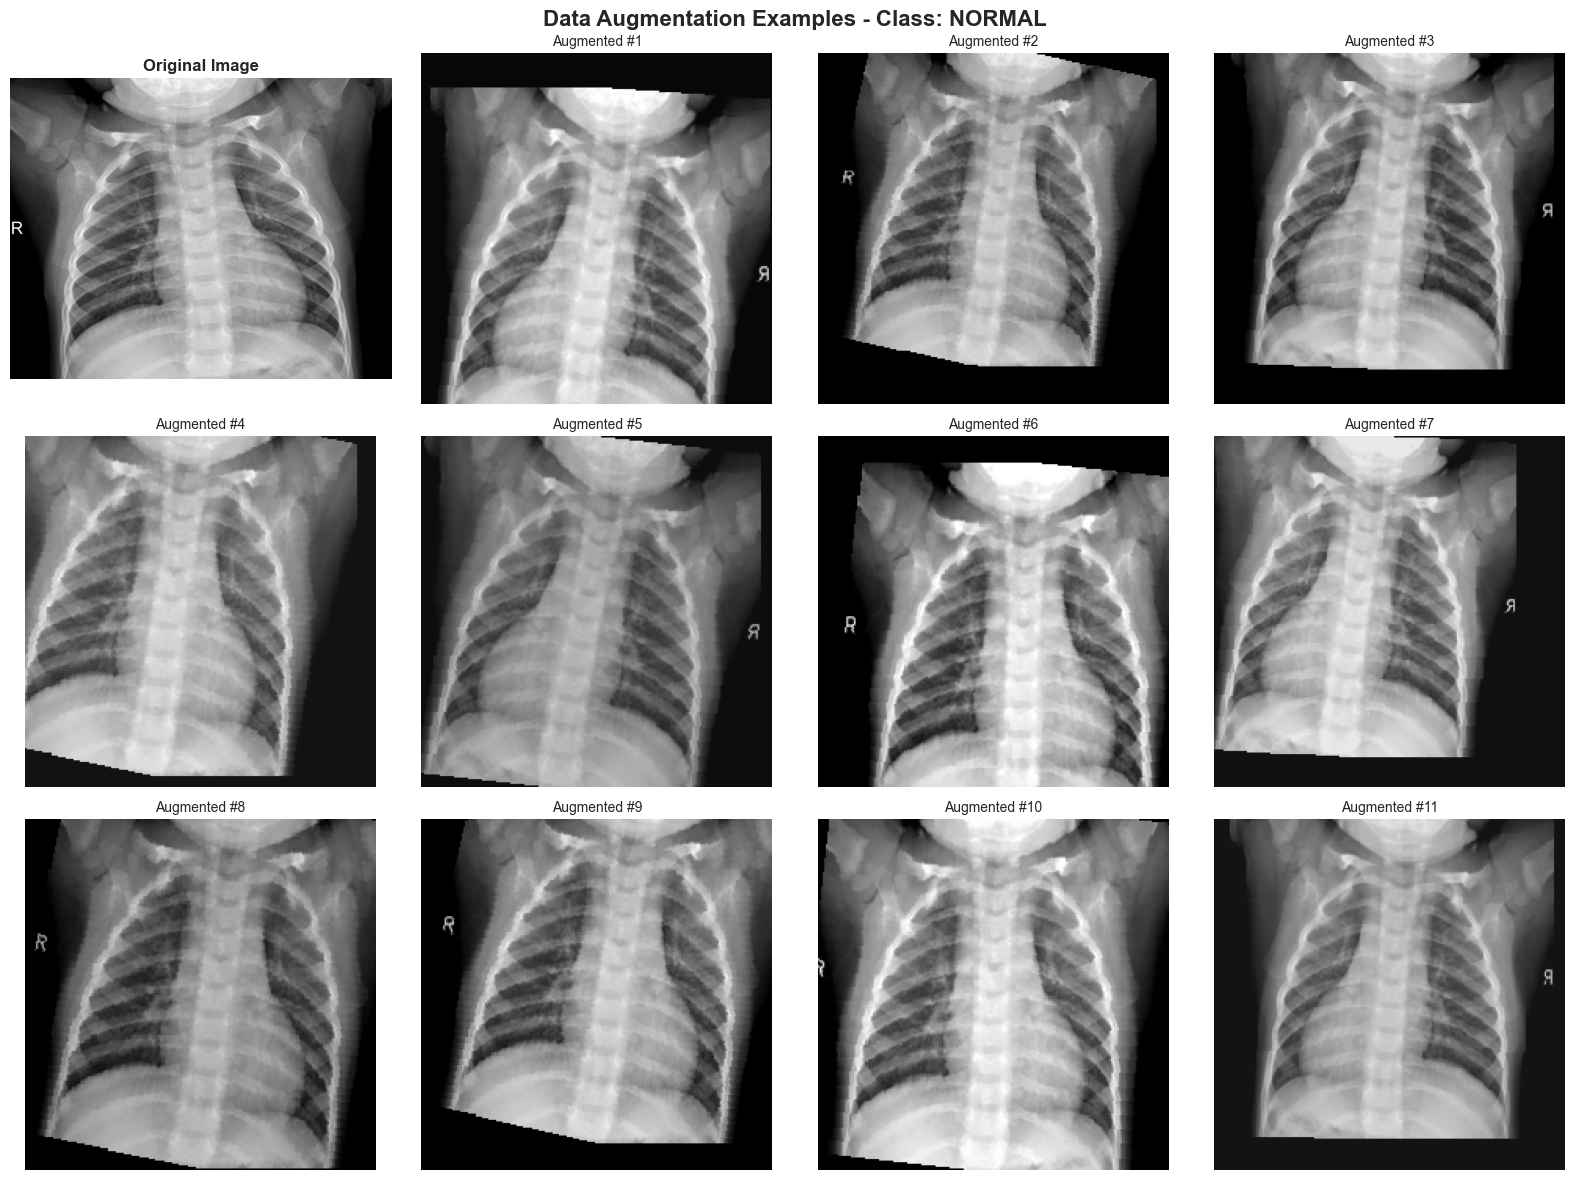

✅ Augmentation visualization complete!

📌 Notice:
  • Each augmented image is different (random transformations)
  • Rotations, flips, brightness changes are visible
  • This diversity helps the model generalize better


In [14]:
# Helper function to denormalize images for visualization
def denormalize(tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """Denormalize a tensor image for visualization."""
    # Clone to avoid modifying original
    tensor = tensor.clone()
    
    # Denormalize
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    
    # Clip to valid range
    tensor = torch.clamp(tensor, 0, 1)
    
    return tensor

# Select a sample image (NORMAL class)
sample_idx = 50  # Adjust as needed
original_img_path, label = train_dataset.samples[sample_idx]

# Load original image
original_img = Image.open(original_img_path).convert('RGB')

# Create figure
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle(f'Data Augmentation Examples - Class: {train_dataset.classes[label]}', 
             fontsize=16, fontweight='bold')

# Show original image
axes[0, 0].imshow(original_img)
axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')
axes[0, 0].set_facecolor('#f0f0f0')

# Apply augmentation 11 times
for i in range(1, 12):
    # Get augmented image
    img_tensor, _ = train_dataset[sample_idx]
    
    # Denormalize for visualization
    img_denorm = denormalize(img_tensor)
    
    # Convert to numpy
    img_np = img_denorm.permute(1, 2, 0).numpy()
    
    # Plot
    row = i // 4
    col = i % 4
    axes[row, col].imshow(img_np)
    axes[row, col].set_title(f'Augmented #{i}', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print("✅ Augmentation visualization complete!")
print("\n📌 Notice:")
print("  • Each augmented image is different (random transformations)")
print("  • Rotations, flips, brightness changes are visible")
print("  • This diversity helps the model generalize better")

## 🔬 Compare Train vs Test Transforms

Visualize the difference between augmented (train) and non-augmented (test) images.

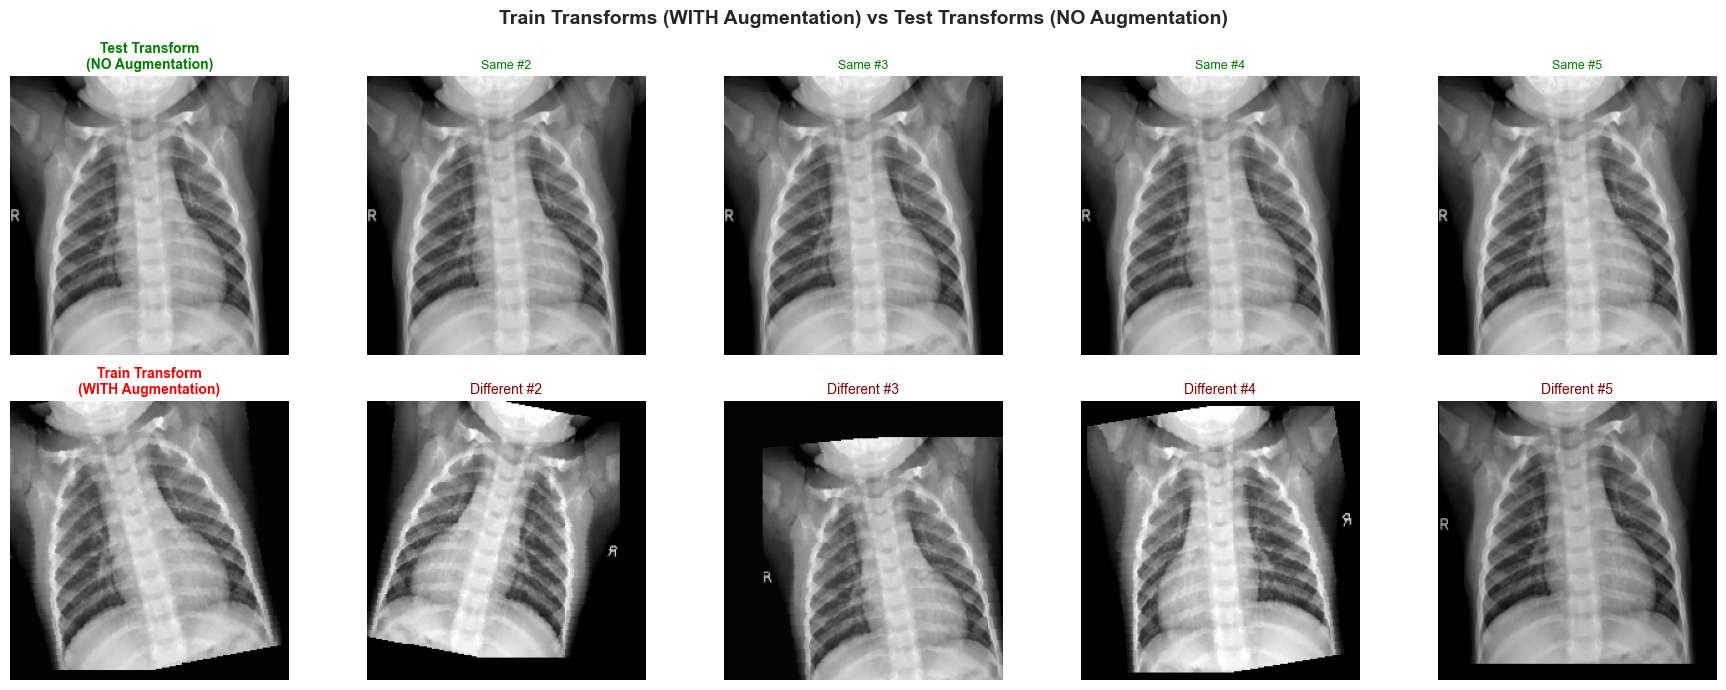

KEY OBSERVATIONS:
✅ Test transforms (top row):
   • All 5 images are IDENTICAL
   • No randomness - deterministic preprocessing
   • Ensures fair evaluation metrics

✅ Train transforms (bottom row):
   • All 5 images are DIFFERENT
   • Random augmentation creates diversity
   • Helps model learn robust features

⚠️ CRITICAL: Never use augmentation on validation/test data!
   This would artificially inflate your metrics (data leakage)


In [15]:
# Create test dataset for comparison
test_dataset_for_comparison = ChestXRayDataset(DATA_DIR, split='train', transform=val_test_transforms)

# Select same sample
sample_idx = 50

# Get images
train_img, label = train_dataset[sample_idx]  # With augmentation
test_img, _ = test_dataset_for_comparison[sample_idx]  # Without augmentation

# Create comparison
fig, axes = plt.subplots(2, 5, figsize=(18, 7))
fig.suptitle('Train Transforms (WITH Augmentation) vs Test Transforms (NO Augmentation)', 
             fontsize=14, fontweight='bold')

# Test transform (no augmentation) - always the same
test_img_denorm = denormalize(test_img.clone())
test_img_np = test_img_denorm.permute(1, 2, 0).numpy()

axes[0, 0].imshow(test_img_np)
axes[0, 0].set_title('Test Transform\n(NO Augmentation)', fontsize=10, fontweight='bold', color='green')
axes[0, 0].axis('off')
axes[0, 0].set_facecolor('#e8f5e9')

# Show 4 more times (all identical)
for i in range(1, 5):
    test_img_2, _ = test_dataset_for_comparison[sample_idx]
    test_img_denorm_2 = denormalize(test_img_2.clone())
    test_img_np_2 = test_img_denorm_2.permute(1, 2, 0).numpy()
    
    axes[0, i].imshow(test_img_np_2)
    axes[0, i].set_title(f'Same #{i+1}', fontsize=9, color='green')
    axes[0, i].axis('off')
    axes[0, i].set_facecolor('#e8f5e9')

# Train transform (with augmentation) - all different
for i in range(5):
    train_img_aug, _ = train_dataset[sample_idx]
    train_img_denorm = denormalize(train_img_aug.clone())
    train_img_np = train_img_denorm.permute(1, 2, 0).numpy()
    
    title = 'Train Transform\n(WITH Augmentation)' if i == 0 else f'Different #{i+1}'
    color = 'red' if i == 0 else 'darkred'
    
    axes[1, i].imshow(train_img_np)
    axes[1, i].set_title(title, fontsize=10, fontweight='bold' if i == 0 else 'normal', color=color)
    axes[1, i].axis('off')
    axes[1, i].set_facecolor('#ffebee')

plt.tight_layout()
plt.show()

print("="*70)
print("KEY OBSERVATIONS:")
print("="*70)
print("✅ Test transforms (top row):")
print("   • All 5 images are IDENTICAL")
print("   • No randomness - deterministic preprocessing")
print("   • Ensures fair evaluation metrics")
print()
print("✅ Train transforms (bottom row):")
print("   • All 5 images are DIFFERENT")
print("   • Random augmentation creates diversity")
print("   • Helps model learn robust features")
print()
print("⚠️ CRITICAL: Never use augmentation on validation/test data!")
print("   This would artificially inflate your metrics (data leakage)")
print("="*70)

## 📦 Create DataLoaders

DataLoaders handle batching, shuffling, and parallel loading.

In [16]:
# Create DataLoaders
train_loader = data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle training data
    num_workers=0,  # Use 0 for notebook compatibility
    pin_memory=False
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Don't shuffle validation data
    num_workers=0,  # Use 0 for notebook compatibility
    pin_memory=False
)

test_loader = data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Don't shuffle test data
    num_workers=0,  # Use 0 for notebook compatibility
    pin_memory=False
)

print("="*60)
print("DATALOADER SUMMARY")
print("="*60)
print(f"Train batches: {len(train_loader)} (batch_size={BATCH_SIZE})")
print(f"Val batches:   {len(val_loader)} (batch_size={BATCH_SIZE})")
print(f"Test batches:  {len(test_loader)} (batch_size={BATCH_SIZE})")
print(f"\nShuffle:")
print(f"  Train: True  (randomize order each epoch)")
print(f"  Val:   False (consistent evaluation)")
print(f"  Test:  False (consistent evaluation)")
print("="*60)

# Test loading a batch
images, labels = next(iter(train_loader))
print(f"\n✅ Batch loaded successfully!")
print(f"   Batch shape: {images.shape}")
print(f"   Labels shape: {labels.shape}")
print(f"   Image dtype: {images.dtype}")
print(f"   Image range: [{images.min():.3f}, {images.max():.3f}]")

DATALOADER SUMMARY
Train batches: 163 (batch_size=32)
Val batches:   1 (batch_size=32)
Test batches:  20 (batch_size=32)

Shuffle:
  Train: True  (randomize order each epoch)
  Val:   False (consistent evaluation)
  Test:  False (consistent evaluation)

✅ Batch loaded successfully!
   Batch shape: torch.Size([32, 3, 224, 224])
   Labels shape: torch.Size([32])
   Image dtype: torch.float32
   Image range: [-2.118, 2.640]


## 🎯 Visualize a Training Batch

See how augmented images look in a batch.

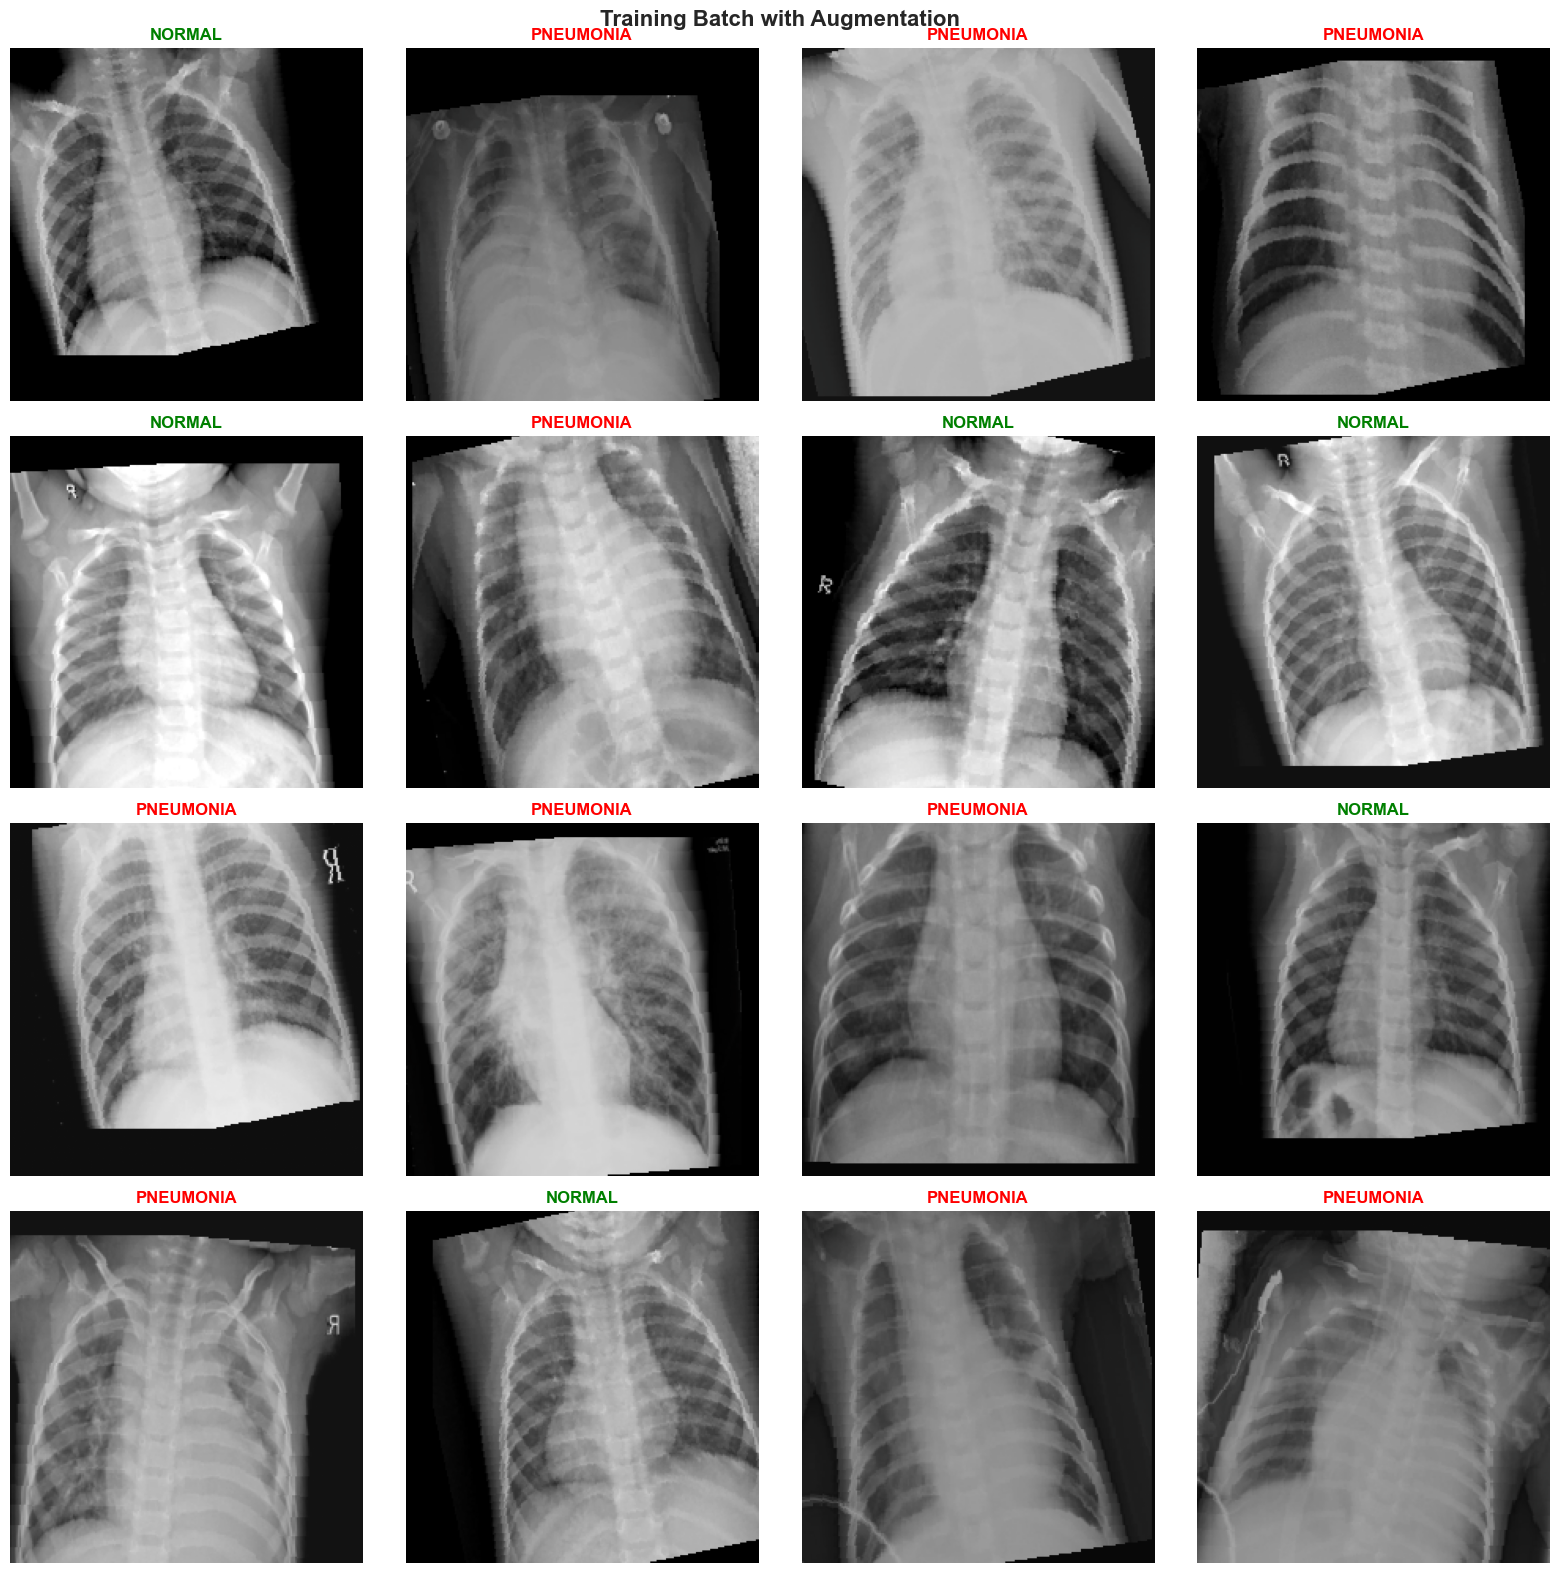

BATCH STATISTICS
Batch size: 32
Normal: 13 (40.6%)
Pneumonia: 19 (59.4%)


In [17]:
# Get a batch from training data
images_batch, labels_batch = next(iter(train_loader))

# Visualize 16 images from the batch
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle('Training Batch with Augmentation', fontsize=16, fontweight='bold')

for i in range(16):
    # Denormalize image
    img = denormalize(images_batch[i].clone())
    img_np = img.permute(1, 2, 0).numpy()
    
    # Get label
    label_idx = labels_batch[i].item()
    label_name = train_dataset.classes[label_idx]
    
    # Plot
    ax = axes[i // 4, i % 4]
    ax.imshow(img_np)
    
    # Color-coded title
    color = 'green' if label_name == 'NORMAL' else 'red'
    ax.set_title(f'{label_name}', fontsize=12, fontweight='bold', color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Count class distribution in batch
normal_count = (labels_batch == 0).sum().item()
pneumonia_count = (labels_batch == 1).sum().item()

print("="*60)
print("BATCH STATISTICS")
print("="*60)
print(f"Batch size: {len(labels_batch)}")
print(f"Normal: {normal_count} ({normal_count/len(labels_batch)*100:.1f}%)")
print(f"Pneumonia: {pneumonia_count} ({pneumonia_count/len(labels_batch)*100:.1f}%)")
print("="*60)

## 📋 Summary of Preprocessing Pipeline

Key takeaways and best practices.

In [18]:
print("="*70)
print("🎯 PREPROCESSING PIPELINE SUMMARY")
print("="*70)

print("\n1. IMAGE RESIZING:")
print(f"   ✓ All images resized to {IMAGE_SIZE}×{IMAGE_SIZE}")
print("   ✓ Standard size for pretrained models (ResNet50, EfficientNet)")
print("   ✓ Ensures consistent input dimensions")

print("\n2. NORMALIZATION:")
print(f"   ✓ Mean: {IMAGENET_MEAN}")
print(f"   ✓ Std:  {IMAGENET_STD}")
print("   ✓ ImageNet statistics for transfer learning compatibility")
print("   ✓ Applied to ALL splits (train/val/test)")

print("\n3. DATA AUGMENTATION (TRAIN ONLY):")
print("   ✓ RandomHorizontalFlip (p=0.5)")
print("   ✓ RandomRotation (±15°)")
print("   ✓ RandomAffine (translate 10%, scale 90-110%)")
print("   ✓ ColorJitter (brightness ±20%, contrast ±20%)")
print("   ⚠️ NOT applied to validation/test data")

print("\n4. TRAIN vs TEST TRANSFORMS:")
print(f"   ✓ Train:  {len(train_transforms.transforms)} transformation steps (WITH augmentation)")
print(f"   ✓ Val:    {len(val_test_transforms.transforms)} transformation steps (NO augmentation)")
print(f"   ✓ Test:   {len(val_test_transforms.transforms)} transformation steps (NO augmentation)")
print("   ⚠️ Critical difference prevents data leakage!")

print("\n5. DATA LOADING:")
print(f"   ✓ Batch size: {BATCH_SIZE}")
print(f"   ✓ Train loader: {len(train_loader)} batches (shuffled)")
print(f"   ✓ Val loader:   {len(val_loader)} batches (not shuffled)")
print(f"   ✓ Test loader:  {len(test_loader)} batches (not shuffled)")

print("\n6. BENEFITS:")
print("   ✓ Reduces overfitting (data augmentation)")
print("   ✓ Improves generalization (diverse training data)")
print("   ✓ Fair evaluation (no augmentation on test)")
print("   ✓ Transfer learning ready (ImageNet normalization)")
print("   ✓ Efficient loading (DataLoader with parallel workers)")

print("\n7. BEST PRACTICES FOLLOWED:")
print("   ✅ Different transforms for train vs test")
print("   ✅ ImageNet normalization for pretrained models")
print("   ✅ Appropriate augmentation for medical images")
print("   ✅ No data leakage (augmentation only on training)")
print("   ✅ Shuffled training, deterministic validation/test")

print("\n" + "="*70)
print("✅ Preprocessing pipeline complete and ready for training!")
print("="*70)

print("\n📌 NEXT STEPS:")
print("   1. Build model architecture (ResNet50/EfficientNet)")
print("   2. Define loss function with class weights")
print("   3. Train model with these DataLoaders")
print("   4. Evaluate on test set")
print("   5. Implement Grad-CAM for explainability")

🎯 PREPROCESSING PIPELINE SUMMARY

1. IMAGE RESIZING:
   ✓ All images resized to 224×224
   ✓ Standard size for pretrained models (ResNet50, EfficientNet)
   ✓ Ensures consistent input dimensions

2. NORMALIZATION:
   ✓ Mean: [0.485, 0.456, 0.406]
   ✓ Std:  [0.229, 0.224, 0.225]
   ✓ ImageNet statistics for transfer learning compatibility
   ✓ Applied to ALL splits (train/val/test)

3. DATA AUGMENTATION (TRAIN ONLY):
   ✓ RandomHorizontalFlip (p=0.5)
   ✓ RandomRotation (±15°)
   ✓ RandomAffine (translate 10%, scale 90-110%)
   ✓ ColorJitter (brightness ±20%, contrast ±20%)
   ⚠️ NOT applied to validation/test data

4. TRAIN vs TEST TRANSFORMS:
   ✓ Train:  7 transformation steps (WITH augmentation)
   ✓ Val:    3 transformation steps (NO augmentation)
   ✓ Test:   3 transformation steps (NO augmentation)
   ⚠️ Critical difference prevents data leakage!

5. DATA LOADING:
   ✓ Batch size: 32
   ✓ Train loader: 163 batches (shuffled)
   ✓ Val loader:   1 batches (not shuffled)
   ✓ Test 